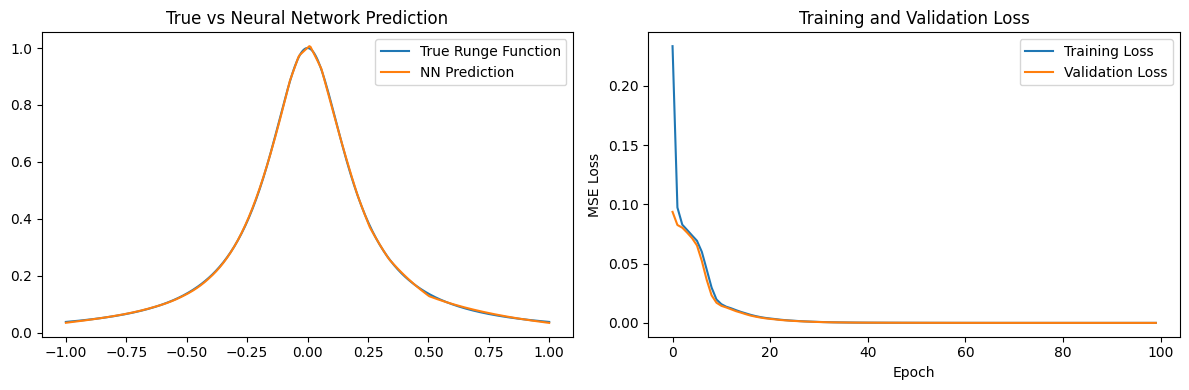

MSE: 0.000006, Max Error: 0.00784


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# === Runge function 定義 ===
def runge_function(x):
    return 1.0 / (1 + 25 * x**2)

# === 建立資料集 ===
np.random.seed(42)
x_train = np.linspace(-1, 1, 1200)
y_train = runge_function(x_train)
x_val = np.linspace(-1, 1, 300)
y_val = runge_function(x_val)

# 轉成 PyTorch tensor
x_train_tensor = torch.FloatTensor(x_train).view(-1, 1)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
x_val_tensor = torch.FloatTensor(x_val).view(-1, 1)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)

train_ds = TensorDataset(x_train_tensor, y_train_tensor)
val_ds = TensorDataset(x_val_tensor, y_val_tensor)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

# === 定義網路 (ReLU + Sigmoid) ===
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))      # 第1層：ReLU
        x = torch.sigmoid(self.fc2(x))   # 第2層：Sigmoid
        x = self.fc3(x)                  # 輸出：線性
        return x

net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
criterion = nn.MSELoss()

# === 訓練迴圈 ===
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    net.train()
    batch_train_losses = []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = net(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        batch_train_losses.append(loss.item())
    train_losses.append(np.mean(batch_train_losses))

    net.eval()
    with torch.no_grad():
        val_pred = net(x_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)
        val_losses.append(val_loss.item())

# === 畫圖 ===
plt.figure(figsize=(12, 4))

# (a) 真實函數 vs NN 預測
plt.subplot(1, 2, 1)
x_plot = np.linspace(-1, 1, 400)
y_true = runge_function(x_plot)
y_pred = net(torch.FloatTensor(x_plot).view(-1, 1)).detach().numpy()
plt.plot(x_plot, y_true, label="True Runge Function")
plt.plot(x_plot, y_pred, label="NN Prediction")
plt.legend()
plt.title("True vs Neural Network Prediction")

# (b) Loss 曲線
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.tight_layout()
plt.show()

# === 計算誤差 ===
mse = np.mean((y_true - y_pred.flatten())**2)
max_error = np.max(np.abs(y_true - y_pred.flatten()))
print(f"MSE: {mse:.6f}, Max Error: {max_error:.5f}")
